In [19]:
# Import Dependencies
import numpy as np
import pandas as pd
import alpaca_trade_api as tradeapi
from datetime import datetime, timedelta, tzinfo, timezone, time,  date
import os
import sys
import ast
import threading
import math
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from alive_progress import alive_bar
import mplfinance as fplt

try:
    from config import *
except:
    from ..config import *

# Establish api from where the data will be pulled
api_paper = tradeapi.REST(PAPER_API_KEY, PAPER_SECRET_KEY, PAPER_BASE_URL, api_version='v2')

### Functions

In [14]:
def pull_data(ticker, interval, api = api_paper, num_of_days = 180, offset_days = 0):
    ticker_data_dict = None
    ticker_data_dict = {}
    monthly_data_dict = None
    monthly_data_dict = {}
    interval_loop_data = None
    interval_loop_data = pd.DataFrame()
    stock_data = None
    
    days_to_collect = num_of_days + offset_days

    TZ = 'US/Eastern'

    start = pd.to_datetime((datetime.now() - timedelta(days=days_to_collect)).strftime("%Y-%m-%d %H:%M"), utc=True)
    end = pd.to_datetime(datetime.now().strftime("%Y-%m-%d %H:%M"), utc=True)

    stock_data = api.get_bars(ticker, interval, start = start.isoformat(), end=end.isoformat(), adjustment="raw").df
    
    interval_loop_data = pd.concat([interval_loop_data, stock_data])
    df_start_ref = interval_loop_data.index[0]
    start_str_ref = pd.to_datetime(start, utc=True)

    while start_str_ref.value < ( pd.to_datetime(df_start_ref, utc=True) - pd.Timedelta(days=2.5)).value:
        end_new = pd.to_datetime(interval_loop_data.index[0].strftime("%Y-%m-%d %H:%M"), utc=True).isoformat()
        stock_data_new = None
        stock_data_new = api.get_bars(ticker, interval, start=start, end=end_new, adjustment="raw").df
        #stock_data_new = stock_data_new.reset_index()
        interval_loop_data = interval_loop_data.append(stock_data_new).sort_values(by=['index'], ascending=True)
        df_start_ref = interval_loop_data.index[0]
        
    stock_yr_min_df = interval_loop_data.copy()
    stock_yr_min_df["Open"] = stock_yr_min_df['open']
    stock_yr_min_df["High"]= stock_yr_min_df["high"]
    stock_yr_min_df["Low"] = stock_yr_min_df["low"]
    stock_yr_min_df["Close"] = stock_yr_min_df["close"]
    stock_yr_min_df["Volume"] = stock_yr_min_df["volume"]
    stock_yr_min_df["VolumeWeightedAvgPrice"] = stock_yr_min_df["vwap"]
    stock_yr_min_df["Time"] = stock_yr_min_df.index.tz_convert(TZ)
    stock_yr_min_df.index = stock_yr_min_df.index.tz_convert(TZ)
    final_df = stock_yr_min_df.filter(["Time", "Open", "High", "Low", "Close", "Volume", "VolumeWeightedAvgPrice"], axis = 1)
    
    first_day = final_df.index[0]
    last_day = final_df.index[-1] - pd.Timedelta(days= offset_days)
    training_df =  final_df.loc[:last_day] 
    offset_df =  final_df.loc[last_day:]
    
    return training_df, offset_df

### Importing raw data

In [16]:
train_df, offset_df = pull_data("NVDA", "5Min", api_paper, num_of_days = 180, offset_days = 0)

### Building Data Plots

In [17]:
train_df

,Time,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice
timestamp,,,,,,,
2021-10-04 04:00:00-04:00,2021-10-04 04:00:00-04:00,205.5300,206.3200,205.2400,205.4900,1187,205.709098
2021-10-04 04:10:00-04:00,2021-10-04 04:10:00-04:00,205.7500,205.7600,205.7500,205.7600,939,205.707934
2021-10-04 04:30:00-04:00,2021-10-04 04:30:00-04:00,205.0000,205.0000,205.0000,205.0000,756,205.000556
2021-10-04 04:35:00-04:00,2021-10-04 04:35:00-04:00,205.0000,205.0000,205.0000,205.0000,1241,204.999984
2021-10-04 04:40:00-04:00,2021-10-04 04:40:00-04:00,204.8200,204.8200,204.8200,204.8200,138,204.823696
...,...,...,...,...,...,...,...
2022-04-01 09:40:00-04:00,2022-04-01 09:40:00-04:00,270.3873,271.4999,269.7000,270.1600,1057462,270.561221
2022-04-01 09:45:00-04:00,2022-04-01 09:45:00-04:00,270.1900,270.1900,268.0700,268.5604,1215381,268.983689
2022-04-01 09:50:00-04:00,2022-04-01 09:50:00-04:00,268.5200,268.6500,266.5500,267.1625,1260342,267.454395


In [26]:
fplt.available_styles()

['binance',
 'blueskies',
 'brasil',
 'charles',
 'checkers',
 'classic',
 'default',
 'ibd',
 'kenan',
 'mike',
 'nightclouds',
 'sas',
 'starsandstripes',
 'yahoo']

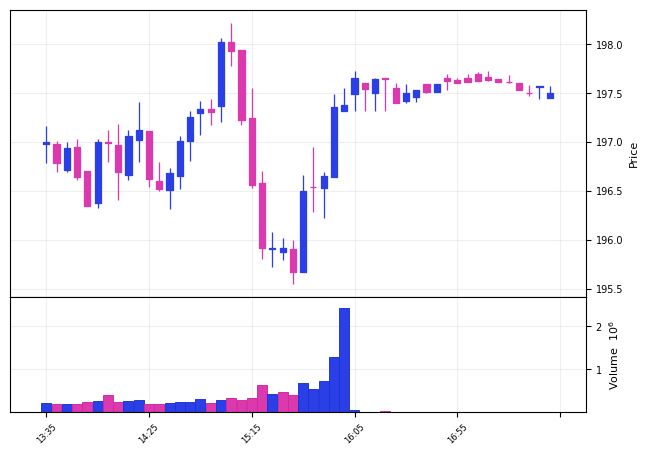

In [42]:
fplt.plot(
            train_df[100:150],
            type='candle',
            style='ibd',
            volume=True,
            show_nontrading=False
            )

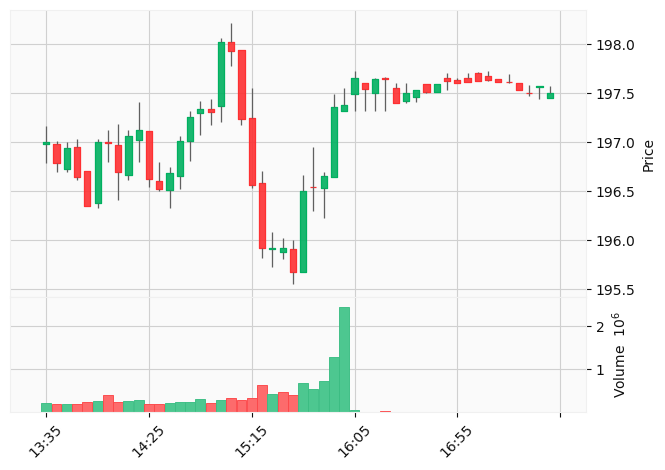

In [33]:
fplt.plot(
            train_df[100:150],
            type='candle',
            style='yahoo',
            volume=True,
            )